In this notebook
1) Get data \
    1.1) Read HDF5 \
    1.2) Select only I channel 
2) Filter with moving average
3) Cut data (discard baseline tale) 
4) Filter data (movinga average)
5) Compute second derivative
6) Get cuspid point on x-axis
7) Select 1/8 of total signal lenght for pre trigger

In [95]:
import h5py
import os
import sys
sys.path.append(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT')
from HDF5 import HDF5
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit

In [2]:
def read(parent):
    data = []
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith('.hdf5'):
                file_path = os.path.join(root, file)
                f = HDF5.HDF5()
                f.name = file_path
                data.append(f.load_hdf5()['Signals']['I'])
    return data


In [3]:
data = read(r'C:\Users\kid\SynologyDrive\Lab2023\KIDs\QTLab2324\IR_SING_PHOT\RUNS\1')

Execution time: 0.169
Execution time: 0.161
Execution time: 0.163
Execution time: 0.172
Execution time: 0.17
Execution time: 0.169
Execution time: 0.183
Execution time: 0.167
Execution time: 0.174
Execution time: 0.17


(xmin, ymin) = (200579,-0.027695648663211614)


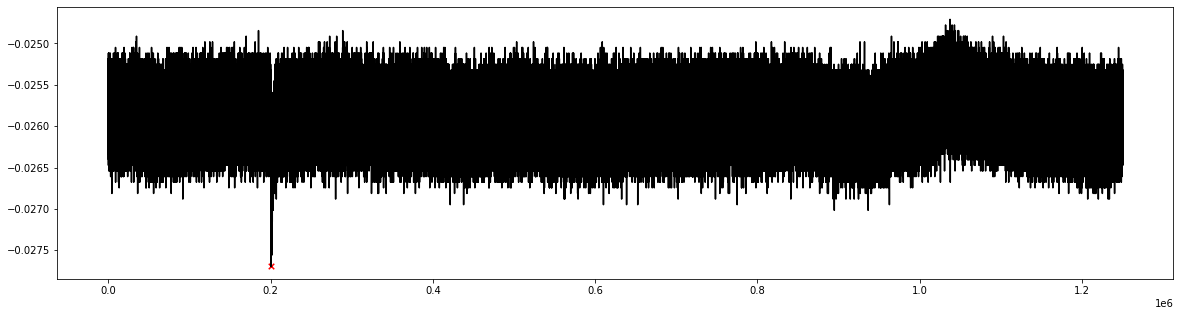

In [5]:
xmin, ymin = [np.argmin(data[1]) , min(data[1])]
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,len(data[1]),len(data[1])),data[1],color='black')
plt.scatter(xmin, ymin, marker='x',color='red',s=30)
print(f'(xmin, ymin) = ({xmin},{ymin})')

In [285]:
#idx = [i for i in range(len(data[1])) if (i<int(0.3*1e6) and i>int(0.15*1e6))]
#I = data[1][idx]

I = data[1][xmin-3000:xmin+10000]
T = np.linspace(xmin-3000,xmin+10000,len(I),dtype=int)

In [286]:
# Apply moving average filter
window_size = 50  # Size of the moving average window
cumsum = np.cumsum(I)
cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
moving_avg = cumsum[window_size - 1:] / window_size
# Pad the moving average to match the length of the original signal
moving_avg = np.pad(moving_avg, (window_size - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))

In [307]:
window_length = 171  # Must be odd
polyorder = 3
sg_filtered_signal = savgol_filter(moving_avg, window_length, polyorder)

# Post-processing: Optional further smoothing
window_size = 5
smoothed_signal = np.convolve(sg_filtered_signal, np.ones(window_size)/window_size, mode='valid')

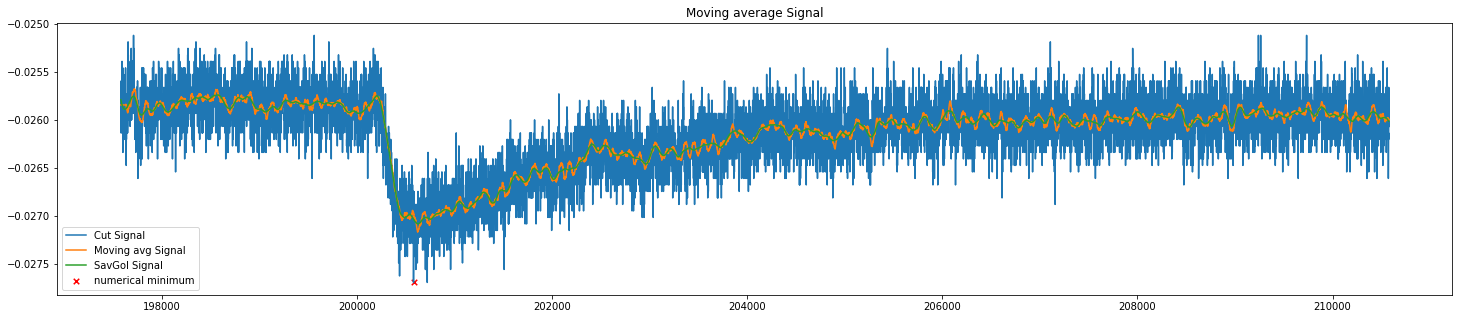

In [308]:
plt.figure(figsize=(25,5))
plt.plot(T, I, label='Cut Signal')
plt.plot(T, moving_avg, label='Moving avg Signal')
plt.plot(T[:len(smoothed_signal)], smoothed_signal, label='SavGol Signal')
plt.scatter(xmin, ymin, marker='x',color='red',s=30,label='numerical minimum')
plt.title('Moving average Signal')
plt.legend()

In [310]:
def model(x, A,B,C,D):
    return A*np.exp(-B*(x-C))+D

In [311]:
p0 = [1,5*1e-5,0,0.026]

In [312]:
popt, pcov = curve_fit(model, T[3000:len(smoothed_signal)], -smoothed_signal[3000:13000], p0)

Text(0.5, 1.0, 'Time constant FIT')

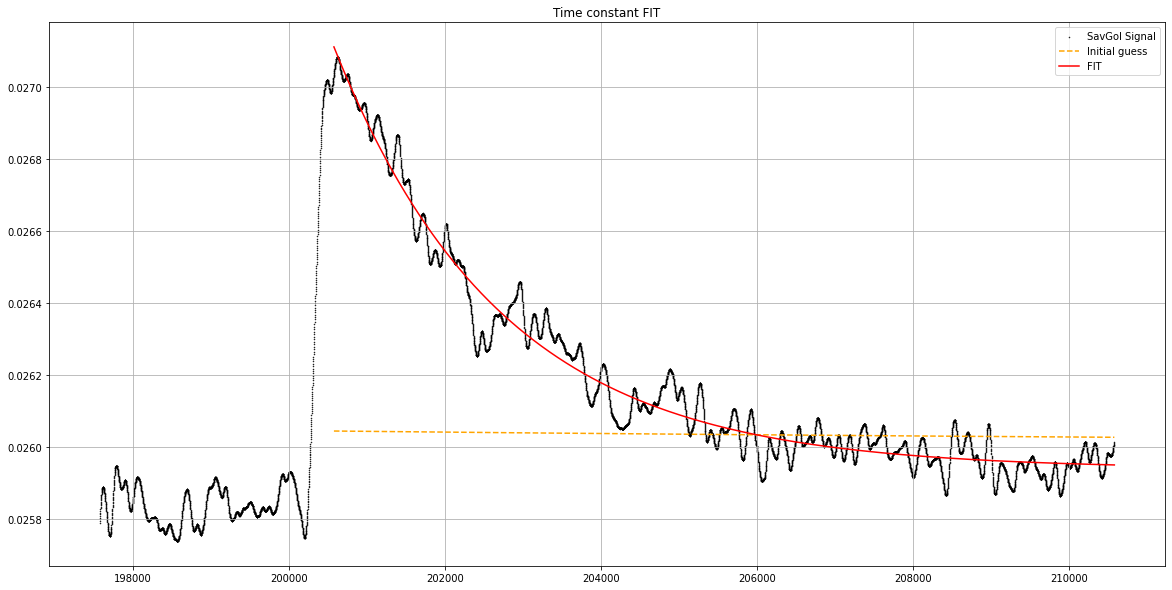

In [313]:
plt.figure(figsize=(20,10))
plt.scatter(T[:len(smoothed_signal)], -smoothed_signal, label='SavGol Signal',marker='.',s=1,color='black')
plt.plot(T[3000:13000],model(T[3000:13000],*p0),label='Initial guess',linestyle='--',color='orange')
plt.plot(T[3000:13000],model(T[3000:13000],*popt),label='FIT',linestyle='-',color='red')
plt.legend()
plt.grid()
plt.title('Time constant FIT')

In [314]:
for i,p in enumerate(popt):
    print(f'Parameter {i} : {p}')

Parameter 0 : 14.169741638093035
Parameter 1 : 0.00046403123256152646
Parameter 2 : 180322.24150359308
Parameter 3 : 0.025938605667996193


In [320]:
window = 11 
polyorder = 3 
fd = savgol_filter(I,window, polyorder, deriv=1) 
sd = savgol_filter(I,window, polyorder, deriv=2) 

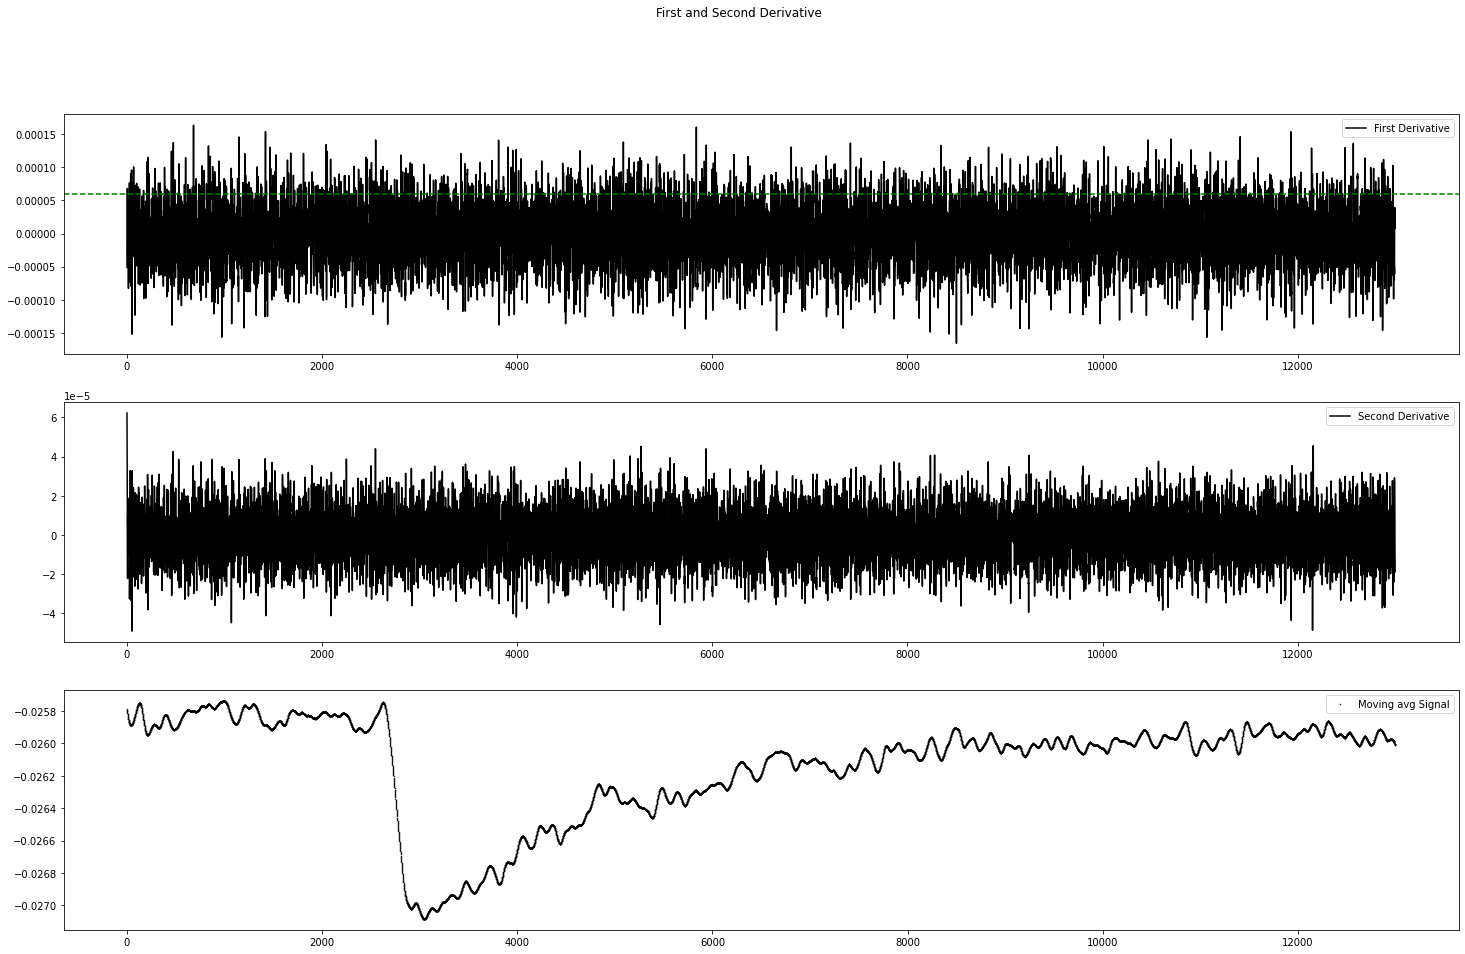

In [325]:
th = 6*1e-5
peaks, props = find_peaks(sd, th,)
fig, axs = plt.subplots(3,1,figsize=(25,15))
axs[1].plot(np.linspace(0,len(sd),len(sd)),sd,color='black',label='Second Derivative')
axs[0].plot(np.linspace(0,len(fd),len(fd)),fd,color='black',label='First Derivative')
#axs[0].axhline(th, 0, 1, linestyle='--', color='green')
axs[2].scatter(np.linspace(0,len(smoothed_signal),len(smoothed_signal)), smoothed_signal, label='Moving avg Signal',marker='.',color='black',s=1)
axs[0].scatter(peaks, props['peak_heights'], marker='x', color='red', s=10)
axs[2].scatter(peaks, smoothed_signal[peaks], marker='x', color='red', s=10)
axs[0].axhline(th, 0, 1, linestyle='--', color='green')
fig.suptitle('First and Second Derivative')
axs[0].legend()
axs[1].legend()
axs[2].legend()

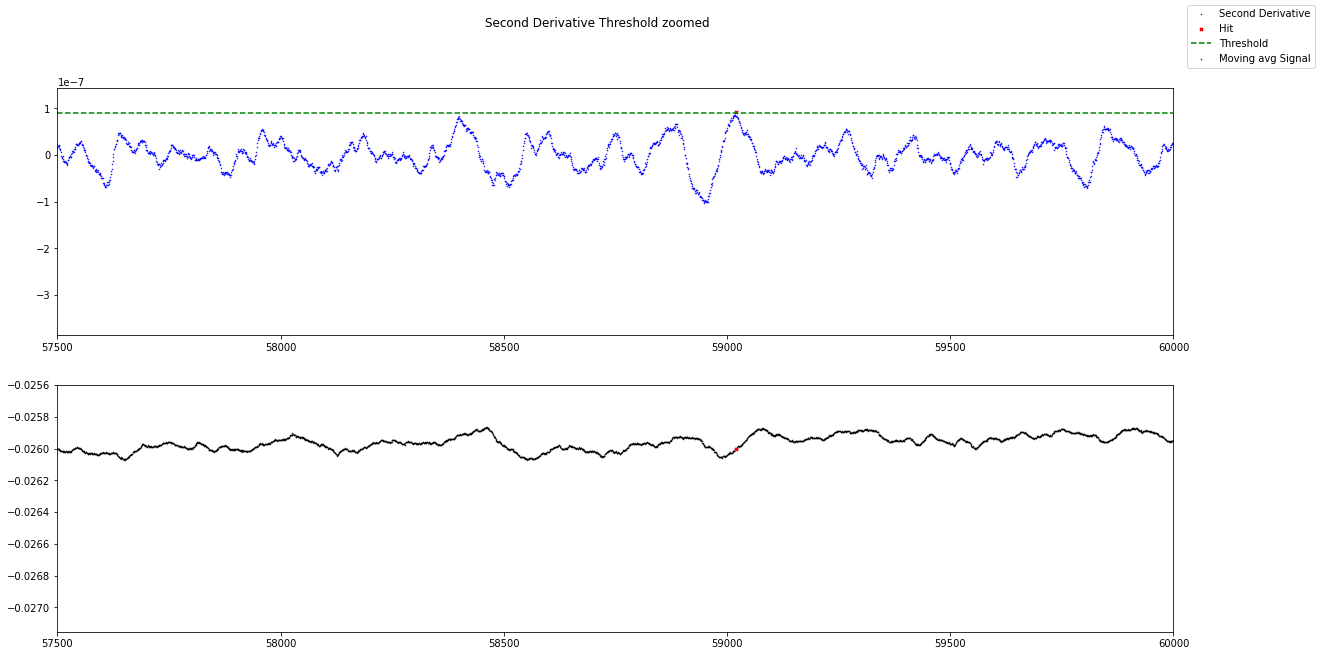

In [227]:
th = 0.9*1e-7
peaks, props = find_peaks(-sd, th)
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].scatter(np.linspace(0,len(sd),len(sd)),-sd,marker='.',color='blue',s=1, label='Second Derivative')
axs[1].scatter(np.linspace(0,len(moving_avg),len(moving_avg)), moving_avg, label='Moving avg Signal',marker='.',color='black',s=1)
axs[0].scatter(peaks, props['peak_heights'], marker='x', color='red', s=10, label='Hit')
axs[1].scatter(peaks, moving_avg[peaks], marker='x', color='red', s=10)
axs[0].axhline(th, 0, 1, linestyle='--', color='green', label='Threshold')
fig.suptitle('Second Derivative Threshold zoomed')
axs[0].set_xlim([5.75*1e4,6*1e4])
axs[1].set_xlim([5.75*1e4,6*1e4])
fig.legend()

In [216]:
with open('Trigger.txt','a') as file:
    file.writelines('\n'+str(peaks[0])+'\t'+str(props['peak_heights'][0]))